# Simulated base inference of SEEG signals using 2D VEP model

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
import scipy as scp


import numba
from numba import jit

import matplotlib.pyplot as plt
from matplotlib import colors, cm

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [4]:
cwd = os.getcwd()
cwd

'/data/VEP_benchmark/VEP_Optimization_Benchmark'

### Constants

In [5]:
I1=3.1
eta_c=-2.05        
delta_eta=1.0                  
prior_std =1.0
sd_thr=0.8

# Patient CJ

In [6]:
cwd = os.getcwd()
cwd

'/data/VEP_benchmark/VEP_Optimization_Benchmark'

## Structural Connectivity and Gain Matrices

In [7]:
weights = np.loadtxt(os.path.join(cwd+"/ExperimentalData/connectivity", "weights.txt"))

In [8]:
# normalize Connectome
weights = weights/np.max(weights)
num_regions = len(weights)

In [9]:
weights.min(), weights.max()

(0.0, 1.0)

In [10]:
Gr = np.loadtxt(os.path.join(cwd+"/ExperimentalData", "gain_inv-square.txt"))

## ROIs chosen as Epileptogenic/propagation zones

In [11]:
hz_val=-3.65
pz_val=-2.4
ez_val=-1.6

ez_idx = np.array([6, 34],  dtype=np.int32)
pz_wplng_idx = np.array([5,11], dtype=np.int32)
pz_kplng_idx = np.array([27], dtype=np.int32)
pz_idx = np.append(pz_kplng_idx, pz_wplng_idx)

In [12]:
#Here, confidential medical information
#Here, confidential medical information
#Here, we increase manually the weights between EZ and PZ to get propagation:
weights[np.ix_(pz_kplng_idx, ez_idx)] = 4.0
weights[np.ix_(pz_wplng_idx, ez_idx)] = 1.0

weights[np.ix_(np.array([5,11]), ez_idx)] = 4.0
weights[np.ix_(np.array([27]), ez_idx)] = 1.0
weights[np.diag_indices(weights.shape[0])] = 0

In [13]:
SC=weights
SC.shape

(84, 84)

### Selected nodes and contacts

In [14]:
from BVEP_Simulator import VEP2Dmodel

### some simulations for  sanity check

In [15]:
T = 14.0
dt=0.1
ts = np.arange(0, T + dt, dt)

In [16]:
nt=ts.shape[0]
nt

141

In [17]:
nn=SC.shape[0]
nn

84

In [18]:
Gr.shape

(162, 84)

In [19]:
ns=Gr.shape[0]
ns

162

In [20]:
tau=10.
sigma=0
constants = np.array([tau, sigma])
constants

array([10.,  0.])

In [21]:
eta_true = np.ones(nn)*hz_val
eta_true[ez_idx] = ez_val
eta_true[pz_idx] = pz_val

In [22]:
K_true=1.

In [23]:
x_init=-2.5
z_init=3.5
init_conditions = np.array([x_init, z_init])

In [24]:
params_true = np.append(eta_true, K_true)
params_true.shape

(85,)

In [25]:
start_time = time.time()
Sim = VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 4.1876585483551025


In [26]:
start_time = time.time()
Sim = VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 0.003237009048461914


In [27]:
X=Sim.reshape(nn, int(Sim.shape[0]/nn))
X.shape

(84, 141)

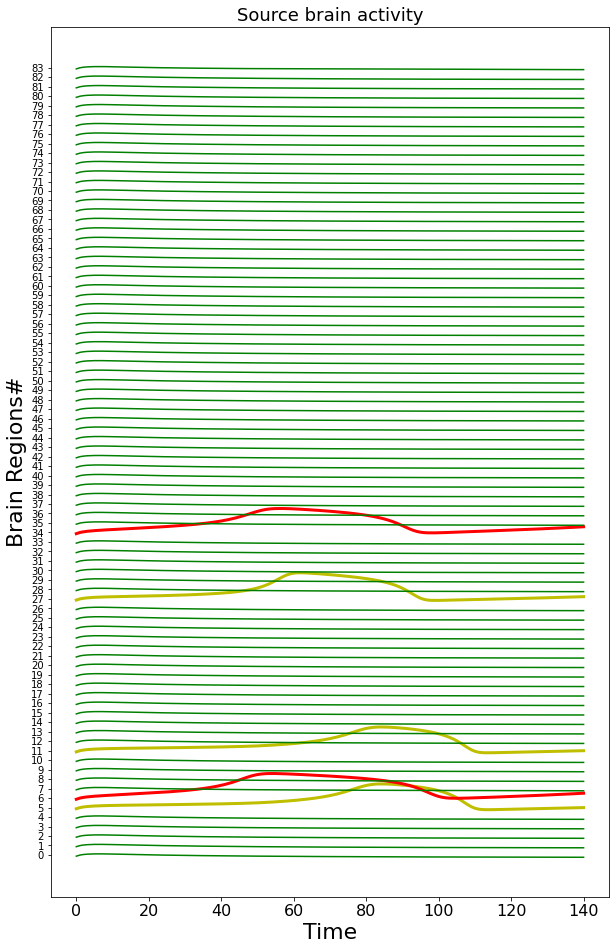

In [28]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(X[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(X[i,:]+i, 'y', lw=3)
    else:  
          plt.plot(X[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.show()

### Seeg signal

In [29]:
X.shape, Gr.shape

((84, 141), (162, 84))

In [30]:
Seeg= np.dot(Gr, np.exp(X))
Seeg.shape

(162, 141)

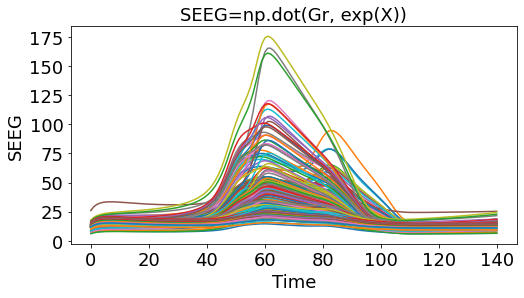

In [31]:
plt.figure(figsize=(8,4))
plt.plot(Seeg.T);
plt.xlabel('Time',fontsize=18)
plt.ylabel('SEEG',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("SEEG=np.dot(Gr, exp(X))",fontsize=18)
plt.show()